In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf

from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.decomposition import PCA

# Pointe-Noire - Time Series modelling

### Abstract
Pointe-Noire is a cape at the Canadian Atlantic coast, situated in the Gulf of St. Lawrence, near the town of Sept-Îles, 
province of Quebec. The port authority of Sept-Îles planned to construct a new shipping port terminal at the site. 
For this purpose, analysis of wave climate is essential for the design of the future infrastructure facility.

Unfortunately, wave data are generally not available at the site and should be collected or hindcasted * at sites offshore 
in deeper water or nearshore in similar water depths. The wave model for hindcast the wave climate at the Canadian Atlantic 
coastal zones is a discrete spectral type called MSC50, elaborated for the Meteorological Service of Canada.

In the present work, input wave time series are used for 14 consecutive years (2 data sets with 1-hour records for the period 
from 1996 to 2009). The objective of our study is to forecast long-term characteristic wave heights (significant wave heights) 
for design purpose in the bay of Pointe Noire (Lat. 50.1 N, Long. 66.5 W). The models applied below are from the Time Series 
analysis.

*) Hindcast is a way of testing mathematical models – entering known inputs for past events into the model to check how well 
the outputs match the known results.

### Pre-processing
First, the input data sets (Time Series) are to be opened and preprocessed.

In [3]:
# Reading the input *.csv file
delimiter = ';'

# # Reading the input *.csv file located in a LOCAL source:
# path_file = "D:\Geo_HP\Geo_ALL\PAPERS\OBOUCHENIE\SoftUni\PYTHON\Machine Learning\jupyter\project\Pointe-Noire_wave_data.csv"
# inp_hindcast_t = pd.read_csv(path_file, sep=delimiter, header=[0, 1], low_memory=False)

# Reading the input *.csv file from Internet:
# # https://github.com/Geo2020/Pointe-Noire/blob/main/Pointe-Noire_wave_data.csv  # old attempt
# https://raw.githubusercontent.com/Geo2020/Pointe-Noire/main/Pointe-Noire_wave_data.csv  # new attempt
path_file = "https://raw.githubusercontent.com/Geo2020/Pointe-Noire/main/Pointe-Noire_wave_data.csv"
inp_hindcast_t = pd.read_csv(path_file, sep=delimiter, header=[0, 1], low_memory=False)

# inp_hindcast_t.head()
inp_hindcast_t  # 61368 rows × 19 columns

,CCYYMM,DDHHmm,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
,-,-,deg,m/s,m^2,sec,deg,m^2,sec,deg,m^2,sec,deg,m^2/s,m2/s2,m,deg,-,-
0,200301,10000,151.0,4.04,0.001,2.129,335.7,0.001,2.041,336.3,0.000,1.336,332.5,0.003,0.006,0.150,335.6,0.9678,0.9397
1,200301,10100,146.8,4.03,0.002,2.317,340.4,0.001,2.073,340.0,0.001,1.794,341.1,0.004,0.008,0.177,340.2,0.9569,0.9206
2,200301,10200,142.7,4.03,0.002,2.434,345.2,0.001,2.036,339.8,0.001,2.056,350.4,0.005,0.010,0.196,344.6,0.9403,0.8922
3,200301,10300,138.6,4.03,0.003,2.500,348.8,0.001,1.991,338.2,0.002,2.197,356.1,0.005,0.011,0.207,348.1,0.9262,0.8678
4,200301,10400,137.2,3.87,0.003,2.512,351.5,0.001,1.868,337.6,0.002,2.293,357.8,0.005,0.011,0.209,350.8,0.9168,0.8514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61363,200912,311900,98.2,1.39,0.000,10.865,327.1,0.000,0.000,278.2,0.000,10.865,327.1,0.000,0.000,0.051,324.2,0.9213,0.8986
61364,200912,312000,89.8,1.38,0.000,10.849,326.3,0.000,0.000,269.8,0.000,10.849,326.3,0.000,0.000,0.051,324.1,0.9322,0.9101
61365,200912,312100,84.8,1.37,0.000,10.836,325.8,0.000,0.000,264.8,0.000,10.836,325.8,0.000,0.000,0.052,324.0,0.9414,0.9199


The main wave climate characteristics (columns’ names) are notated as follow (Oceanweather Inc.):

CCYYMM - Century, Year, Month

DDHHmm - Day, Hour, Minute

WD - Wind Direction, [deg] from which the wind is blowing, clockwise from true North in degrees (meteorological convention).

WS - Wind Speed, [m/s]: 1-hour average of the effective neutral wind at a height of 10 meters.

ETOT - Total Variance of Total Spectrum, [m^2]: the sum of the variance components of the hindcast spectrum, over the 552 bins 
of the 3G wave model.

TP - Peak Spectral Period of Total Spectrum, [sec]: the peak period is the reciprocal of peak frequency. Peak frequency is 
computed by taking the spectral density in each frequency bin, and fitting a parabola to the highest density and one neighbor 
on each side. If highest density is in the .32157 Hz bin, the peak period reported is the peak period of a Pierson-Moskowitz 
spectrum having the same total variance as the hindcast spectrum.

VMD - Vector Mean Direction of Total Spectrum, [deg] to which waves are traveling, clockwise from North (oceanographic 
convention). 

Explanation of sea/swell computation: The sum of the variance components of the hindcast spectrum, over the 552 bins of the 
3G model, in meters squared. To partition "Sea" (primary) and "Swell" (secondary) the model computes a P-M (Pierson-Moskowitz) 
spectrum, with a cos^3 spreading, from the adopted wind speed and direction. For each of the 552 bins, the lesser of the 
hindcast variance component and P-M variance component is thrown into the sea partition; the excess, if any, of hindcast 
over P-M is thrown into the swell partition.

ETTSea - Total Variance of Primary Partition, “Sea”, [m^2].
"Sea" or Wind-sea are waves generated as a result of wind action; they are characterized by short periods (2-10 s) and provide 
an irregular aspect of the sea surface. The Sea state describes the sea surface with regard to wave action. The sea state 
corresponds to a period of time over which the successive individual waves can be regarded as being the results of the same 
random process, so that they have the same average properties in a statistical sense. The characteristic wave heights and 
periods of the sea-state can be obtained by a statistical (wave-by-wave) approach or by a spectral method. The design of 
the marine structures is based mainly on such characteristic values (e.g. significant wave height Hs, mean period Tm etc.), 
representative of the extreme conditions.

TPSea - Peak Spectral Period of Primary Partition, [sec].

VMDSea - Vector Mean Direction of Primary Partition, [deg].

ETTSw - Total Variance of Secondary Partition, “Swell”, [m^2].
Swell waves are generated away from the zone where they are observed and there is no significant effect attributable 
to the local wind; swell usually exhibits a more regular pattern than wind-seas, with longer periods: 10-30 s.

TPSw - Peak Spectral Period of Secondary Partition, [sec].

VMDSw - Vector Mean Direction of Secondary Partition "Sea", [deg].

MO1 - First Spectral Moment (the mean) of Total Spectrum, [m^2/s].

MO2 - Second Spectral Moment of Total Spectrum (the variance, the square root of which is the velocity spectrum width), 
[m^2/s^2].

HS - Significant Wave Height, [m]: 4.0 times the square root of the total variance.

DMDIR - Dominant Direction, [deg]: the angle ψ is determined only to within 180 degrees from North.

ANGSPR - Angular Spreading Function. The angular spreading function is the mean value, over the 552 bins, of cos(θ -VMD), 
weighted by the variance component in each bin (Gumbel, Greenwood & Durand). If the angular spectrum is uniformly 
distributed over 360 degrees, this statistic is zero if uniformly distributed over 180 degrees, 2/π if all variance is 
concentrated at the VMD, 1.

INLINE - In-line Variance Ratio called directional spreading (Haring and Heideman). If spectral variance is uniformly 
distributed over the entire compass, or over a semicircle, Rat = 0.5; if variance is confined to one angular band, 
or to two band 180 degrees apart, Rat = 1.00 . According to Haring and Heideman, cos^2 spreading corresponds to Rat = 0.75.

In [4]:
# Creating a function for reading and pre-processing data (*.csv table):
def input_preprocess(input_df):
    # Dropping the invalid values ('NaN') in the whole DataFrame (if any):
    input_df = input_df.dropna()
    # Dropping the subtitle (the 2nd row):
    new_df_inp = input_df.copy(deep=True)
    new_df_inp.columns = new_df_inp.columns.droplevel(1)
    return new_df_inp

# Reading and pre-processing data (*.csv table):
hindcast_t = input_preprocess(inp_hindcast_t)
# hindcast_t.dtypes  # dtype: object
# hindcast_t  # 61368 rows × 19 columns (DataFrame)

In [5]:
hindcast_t.dtypes

CCYYMM      int64
DDHHmm      int64
WD        float64
WS        float64
ETOT      float64
TP        float64
VMD       float64
ETTSea    float64
TPSea     float64
VMDSea    float64
ETTSw     float64
TPSw      float64
VMDSw     float64
MO1       float64
MO2       float64
HS        float64
DMDIR     float64
ANGSPR    float64
INLINE    float64
dtype: object

Description of the input data table with its main statistical parameters is given below.

In [6]:
inp_hindcast_t.describe().T

,,count,mean,std,min,25%,50%,75%,max
CCYYMM,-,61368.0,200606.522487,200.031364,200301.0,200410.000000,200607.0000,200804.0000,200912.0000
DDHHmm,-,61368.0,158459.346891,88009.839360,10000.0,81400.000000,160500.0000,231900.0000,312300.0000
WD,deg,61368.0,213.480022,96.740054,0.0,134.700000,245.8000,289.4000,360.0000
WS,m/s,61368.0,4.147557,2.050471,0.3,2.610000,3.8500,5.3600,17.4900
ETOT,m^2,61368.0,0.008748,0.020105,0.0,0.000000,0.0010,0.0090,0.5320
TP,sec,61368.0,4.062689,2.998957,0.0,1.867000,3.5900,6.0180,18.3040
VMD,deg,61368.0,188.246021,139.218825,0.0,45.600000,181.7500,326.0000,400.0000
ETTSea,m^2,61368.0,0.005824,0.016385,0.0,0.000000,0.0000,0.0040,0.5160
TPSea,sec,61368.0,1.604229,1.567149,0.0,0.050000,1.0760,2.8920,9.8040
VMDSea,deg,61368.0,149.624079,123.452402,0.0,51.900000,109.8500,265.3000,400.0000


### Creating 'Date-Time' column:

Below we create a function for converting Date - Time values:

In [7]:
def date_time_converting(df):
    # Dividing Date's and Time's components:
    year = (df.CCYYMM / 100).astype("int")
    month = (df.CCYYMM % 100).astype("int")
    # in 'Day - Hour - Minute' column DDHHmm:
    minute = (df.DDHHmm % 100).astype("int")
    hour = ((df.DDHHmm // 100) % 100).astype("int")
    day = (df.DDHHmm // 10000).astype("int")
    # Creating a new table for the Date:
    date = pd.DataFrame(year)
    date = date.rename(columns={'CCYYMM': 'Year'})    
    date = pd.concat([date, pd.DataFrame(month), pd.DataFrame(day)], axis=1)   
    date = date.rename(columns={'CCYYMM': 'Month', 'DDHHmm': 'Day'})
    
    # Creating a new table for the Time [hour - min - sec]:
    time = pd.DataFrame(hour)
    time = time.rename(columns={'DDHHmm': 'Hour'})
    time = pd.concat([time, pd.DataFrame(minute)], axis=1)
    time = time.rename(columns={'DDHHmm': 'Minute'})
    
    # Adding Date-Time column to the data table:
    date_formatted = date.Day.astype("str") + "/" + date.Month.astype("str") + "/" + date.Year.astype("str")
    time_formatted = time.Hour.astype("str") + ":" + time.Minute.astype("str")
    df["DateTime"] = pd.to_datetime(date_formatted + " " + time_formatted)
    df.DateTime
    
    # Dropping 2 old columns from the DataFrame:
    df = df.drop(["CCYYMM", "DDHHmm"], axis = 1)
    
    return df

In [8]:
# Converting Date-Time values:
hindcast_t = date_time_converting(hindcast_t)
hindcast_t  # 61368 rows × 18 columns

,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE,DateTime
0,151.0,4.04,0.001,2.129,335.7,0.001,2.041,336.3,0.000,1.336,332.5,0.003,0.006,0.150,335.6,0.9678,0.9397,2003-01-01 00:00:00
1,146.8,4.03,0.002,2.317,340.4,0.001,2.073,340.0,0.001,1.794,341.1,0.004,0.008,0.177,340.2,0.9569,0.9206,2003-01-01 01:00:00
2,142.7,4.03,0.002,2.434,345.2,0.001,2.036,339.8,0.001,2.056,350.4,0.005,0.010,0.196,344.6,0.9403,0.8922,2003-01-01 02:00:00
3,138.6,4.03,0.003,2.500,348.8,0.001,1.991,338.2,0.002,2.197,356.1,0.005,0.011,0.207,348.1,0.9262,0.8678,2003-01-01 03:00:00
4,137.2,3.87,0.003,2.512,351.5,0.001,1.868,337.6,0.002,2.293,357.8,0.005,0.011,0.209,350.8,0.9168,0.8514,2003-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61363,98.2,1.39,0.000,10.865,327.1,0.000,0.000,278.2,0.000,10.865,327.1,0.000,0.000,0.051,324.2,0.9213,0.8986,2009-12-31 19:00:00
61364,89.8,1.38,0.000,10.849,326.3,0.000,0.000,269.8,0.000,10.849,326.3,0.000,0.000,0.051,324.1,0.9322,0.9101,2009-12-31 20:00:00
61365,84.8,1.37,0.000,10.836,325.8,0.000,0.000,264.8,0.000,10.836,325.8,0.000,0.000,0.052,324.0,0.9414,0.9199,2009-12-31 21:00:00
61366,82.3,1.36,0.000,10.823,325.3,0.000,0.000,262.3,0.000,10.823,325.3,0.000,0.000,0.052,324.1,0.9492,0.9281,2009-12-31 22:00:00


Now, we check if Date - Time values are unique:

In [9]:
hindcast_t.DateTime.is_unique

True

Then, we set 'DateTime' column as index creating a function for this purpose:

In [10]:
def set_date_time_as_index(df_2):
    # Setting the column 'DateTime' as an index:
    df_2 = df_2.set_index("DateTime")
    # Sorting the dataset by index:
    df_2 = df_2.sort_index()
    return df_2

In [11]:
hindcast_t = set_date_time_as_index(hindcast_t)
hindcast_t.index

DatetimeIndex(['2003-01-01 00:00:00', '2003-01-01 01:00:00',
               '2003-01-01 02:00:00', '2003-01-01 03:00:00',
               '2003-01-01 04:00:00', '2003-01-01 05:00:00',
               '2003-01-01 06:00:00', '2003-01-01 07:00:00',
               '2003-01-01 08:00:00', '2003-01-01 09:00:00',
               ...
               '2009-12-31 14:00:00', '2009-12-31 15:00:00',
               '2009-12-31 16:00:00', '2009-12-31 17:00:00',
               '2009-12-31 18:00:00', '2009-12-31 19:00:00',
               '2009-12-31 20:00:00', '2009-12-31 21:00:00',
               '2009-12-31 22:00:00', '2009-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=61368, freq=None)

In [12]:
# replacing the missing (NaN) data with a linear interpolation of the missing ('NaN') values:
hindcast_t = hindcast_t.interpolate("time")

hindcast_t.describe().T
# hindcast_t  # the future input DataFrame (ind.=DateTime): 61368 rows × 17 columns

,count,mean,std,min,25%,50%,75%,max
WD,61368.0,213.480022,96.740054,0.0,134.700000,245.8000,289.4000,360.0000
WS,61368.0,4.147557,2.050471,0.3,2.610000,3.8500,5.3600,17.4900
ETOT,61368.0,0.008748,0.020105,0.0,0.000000,0.0010,0.0090,0.5320
TP,61368.0,4.062689,2.998957,0.0,1.867000,3.5900,6.0180,18.3040
VMD,61368.0,188.246021,139.218825,0.0,45.600000,181.7500,326.0000,400.0000
ETTSea,61368.0,0.005824,0.016385,0.0,0.000000,0.0000,0.0040,0.5160
TPSea,61368.0,1.604229,1.567149,0.0,0.050000,1.0760,2.8920,9.8040
VMDSea,61368.0,149.624079,123.452402,0.0,51.900000,109.8500,265.3000,400.0000
ETTSw,61368.0,0.002902,0.006776,0.0,0.000000,0.0010,0.0030,0.1380
TPSw,61368.0,4.558339,3.311189,0.0,1.895000,4.4320,7.3330,24.5000


In the pre-processed data set, we will investigate the behaviuor of the significant wave height Hs - the most important 
parameter for designing of hydrotechnical structures. The Significant wave height is defined as the average height of 
the highest one-third of the waves in the given sea state (data set).
To visualize the time dependence of the Significant wave height we create appropriate functions.

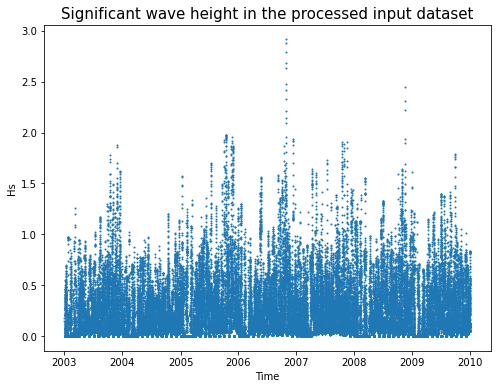

In [13]:
# Creating function for 'scatter' plot:
def plot_scatter(data, column_name, ylabel, title_lable):
    plt.figure(figsize = (8, 6))
    plt.scatter(data.index, data[column_name], s=1)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title_lable, fontsize=15)
    plt.show()

# plot_scatter(hindcast_t_reduced, "HS", "Significant wave height")  # for reduced features
plot_scatter(data=hindcast_t, column_name="HS", ylabel="Hs", 
             title_lable="Significant wave height in the processed input dataset")
# max(hindcast_t['HS'])  # 2.916

In [14]:
# Creating function for plotting:
def plot_evolution(data, column_name, ylabel, title_lable='Significant wave height'):
    plt.figure(figsize = (8, 6))
    plt.plot(data.index, data[column_name])
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title_lable, fontsize=15)
    plt.show()

Below an example for 1 month data set is given:

In [15]:
hindcast_t_jan2003 = hindcast_t.loc["2003/01/01":"2003/01/31"]

In [16]:
# Example with 1-month data:
hindcast_t_jan2003  # 744 rows × 17 columns

,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
DateTime,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,151.0,4.04,0.001,2.129,335.7,0.001,2.041,336.3,0.000,1.336,332.5,0.003,0.006,0.150,335.6,0.9678,0.9397
2003-01-01 01:00:00,146.8,4.03,0.002,2.317,340.4,0.001,2.073,340.0,0.001,1.794,341.1,0.004,0.008,0.177,340.2,0.9569,0.9206
2003-01-01 02:00:00,142.7,4.03,0.002,2.434,345.2,0.001,2.036,339.8,0.001,2.056,350.4,0.005,0.010,0.196,344.6,0.9403,0.8922
2003-01-01 03:00:00,138.6,4.03,0.003,2.500,348.8,0.001,1.991,338.2,0.002,2.197,356.1,0.005,0.011,0.207,348.1,0.9262,0.8678
2003-01-01 04:00:00,137.2,3.87,0.003,2.512,351.5,0.001,1.868,337.6,0.002,2.293,357.8,0.005,0.011,0.209,350.8,0.9168,0.8514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-01-31 19:00:00,195.6,3.68,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0000,0.0000
2003-01-31 20:00:00,192.9,3.55,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0000,0.0000
2003-01-31 21:00:00,190.0,3.41,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.0,0.0000,0.0000


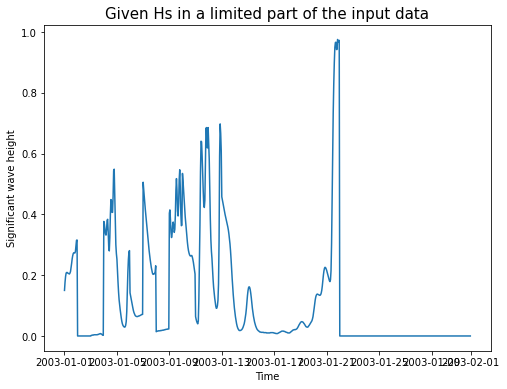

In [17]:
plot_evolution(data=hindcast_t_jan2003, column_name='HS', ylabel='Significant wave height', 
               title_lable='Given Hs in a limited part of the input data')
# max(hindcast_t['HS'].loc["2003/01/01":"2003/01/31"])  # 0.976

In [18]:
# replacing the missing ('NaN') data with a linear interpolation of the missing values:
# hindcast_t.describe().T
hindcast_t = hindcast_t.interpolate("time")
# hindcast_t.describe().T
hindcast_t  # DataFrame: 61368 rows × 17 columns (index=DateTime, columns: incl. HS)

,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
DateTime,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,151.0,4.04,0.001,2.129,335.7,0.001,2.041,336.3,0.000,1.336,332.5,0.003,0.006,0.150,335.6,0.9678,0.9397
2003-01-01 01:00:00,146.8,4.03,0.002,2.317,340.4,0.001,2.073,340.0,0.001,1.794,341.1,0.004,0.008,0.177,340.2,0.9569,0.9206
2003-01-01 02:00:00,142.7,4.03,0.002,2.434,345.2,0.001,2.036,339.8,0.001,2.056,350.4,0.005,0.010,0.196,344.6,0.9403,0.8922
2003-01-01 03:00:00,138.6,4.03,0.003,2.500,348.8,0.001,1.991,338.2,0.002,2.197,356.1,0.005,0.011,0.207,348.1,0.9262,0.8678
2003-01-01 04:00:00,137.2,3.87,0.003,2.512,351.5,0.001,1.868,337.6,0.002,2.293,357.8,0.005,0.011,0.209,350.8,0.9168,0.8514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,98.2,1.39,0.000,10.865,327.1,0.000,0.000,278.2,0.000,10.865,327.1,0.000,0.000,0.051,324.2,0.9213,0.8986
2009-12-31 20:00:00,89.8,1.38,0.000,10.849,326.3,0.000,0.000,269.8,0.000,10.849,326.3,0.000,0.000,0.051,324.1,0.9322,0.9101
2009-12-31 21:00:00,84.8,1.37,0.000,10.836,325.8,0.000,0.000,264.8,0.000,10.836,325.8,0.000,0.000,0.052,324.0,0.9414,0.9199


## EXOGENOUS Model
In Time Series analysis three basic models are used: Exogenous, Endogenous (Autoregression) and Combined method (including 
the previous two). The Exogenous model considers only the external features, i.e. the target variable does not depend on time.
This model is performed below, in which the significant wave height's dependence on other exogenous features is investigated.

First, we separate the pre-processed input data to obtain a training and testing data sets:

In [19]:
# Splitting data to training and testing parts:
exo_train, exo_test, exo_Hs_train, exo_Hs_test = train_test_split(
    hindcast_t.drop("HS", axis = 1), hindcast_t["HS"], train_size = 0.8)
# exo_train, exo_test, exo_Hs_train, exo_Hs_test are NOT sorted by time (index) 
# but it is NOT needed because it is NOT Time Series (pure Exogenous model)

# exo_train  # DataFrame (index: NOT ordered DateTime; named columns: 'WD', 'WS' etc.): 49094 rows × 16 columns
# exo_test  # DataFrame (index: NOT ordered DateTime; named columns: 'WD', 'WS' etc.): 12274 rows × 16 columns
# exo_Hs_train  # DataFrame (index: NOT ordered DateTime) Name: HS, Length: 49094, dtype: float64
# exo_Hs_test  # DataFrame (index: NOT ordered DateTime) Name: HS, Length: 12274, dtype: float64

Linear regression model is chosen for analysis:

In [20]:
linear_regress = LinearRegression()
linear_regress.fit(exo_train, exo_Hs_train)

LinearRegression()

We create a function calculating 'score' of the training and testing datasets:

In [21]:
def show_scores(estimator, data_train, data_test, target_train, target_test):
    print("Train score: {}".format(estimator.score(data_train, target_train)))
    print("Test score: {}".format(estimator.score(data_test, target_test)))

# Score results:
show_scores(linear_regress, exo_train, exo_test, exo_Hs_train, exo_Hs_test)

Train score: 0.9653488711976154
Test score: 0.964088995494574


The predicted Significant wave heights are obtained from the Linear exogenous model:

In [22]:
# Prediction results:
exo_test_prediction = linear_regress.predict(exo_test)
exo_test_prediction

array([1.16568139, 0.52596829, 0.49096161, ..., 0.61644463, 0.00499354,
       0.21974028])

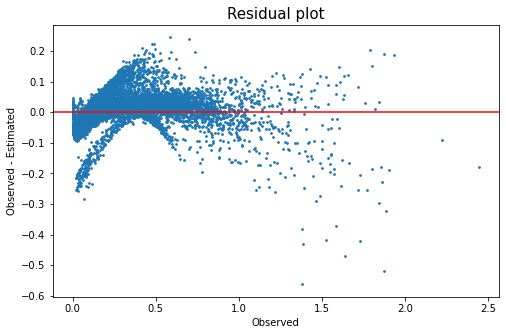

In [23]:
# creating function for Residual plot:
def residual_plot(observed, estimated):
    plt.figure(figsize = (8, 5))
    plt.scatter(observed, observed - estimated, s = 3)
    plt.axhline(0, c = "red")
    plt.xlabel("Observed")
    plt.ylabel("Observed - Estimated")
    plt.title('Residual plot', fontsize=15)
    plt.show()

residual_plot(exo_Hs_test, exo_test_prediction)

The Mean and Standard deviation of the difference between the hindcasted and predicted wave heights are found below:

In [24]:
(exo_Hs_test - exo_test_prediction).mean()

-0.0007421044143909262

In [25]:
(exo_Hs_test - exo_test_prediction).std()

0.05236422089161343

The correlation coefficients of the features are shown below:

In [26]:
linear_regress.coef_
# Computing Correlation between the variables (between -1 and 1)
# hindcast_t.corr()

array([-2.96600261e-06, -5.52313095e-03, -3.15801447e+00,  3.71741667e-03,
       -4.15028606e-06, -5.49351991e+00,  4.84998542e-02, -2.26442418e-05,
        1.99140570e+00, -2.30249211e-03, -2.38260155e-05,  1.00072499e+01,
        1.71293972e+00,  8.34830046e-05,  8.19208913e-02, -3.63132433e-02])

As an example, we visualize a sample of predicted Significant wave heights (the last 200 waves):

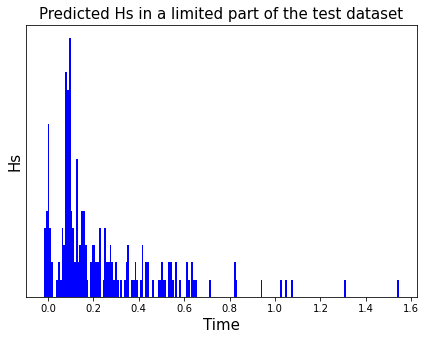

In [27]:
np_hist_pred_exo = linear_regress.predict(exo_test[-200:])
# print(f"Maximum predicted Hs in the chosen data set: {max(np_hist_pred_exo)}")  # 2.032

def plot_histogram(np_hist, y_label='Hs', title_label='Predicted Hs in a limited part of the test dataset'):
    plt.figure(figsize=[7, 5])
    n, bins, patches = plt.hist(x=np_hist, bins=len(np_hist), color='blue', rwidth=1)  # alpha - transparency
    plt.xlabel('Time', fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    # max_y = max(np_hist)
    max_input_data_Hs = max(hindcast_t['HS'])
    # plt.ylim(0, round(max_input_data_Hs))  # plots the limits on the axis
    # plt.yticks(range(0, round(max_input_data_Hs)))
    plt.yticks([])  # disables yticks
    plt.title(title_label, fontsize=15)
    plt.show()

plot_histogram(np_hist_pred_exo)

The model determines the maximum of the predicted Significant wave heights for the testing data set (using the Exogenous linear 
regression):

In [28]:
# Creating a function for testing data prediction of the maximum wave height:
def predict_value_func(estime_model, inp_dataset, inp_target):
    inp_test_prediction = estime_model.predict(inp_dataset)
    max_predict_Hs = max(inp_test_prediction)
    print(f"   maximum predicted Hs = {max_predict_Hs:.2f} m")
    max_Hs = max(inp_target)
    # print(f"   real maximum Hs = {max_Hs:.2f} m")
    # print(f"   relative error = {abs(max_predict_Hs - max_Hs)/max(max_predict_Hs, max_Hs):.3f}")

print("In the Exogenous model (Linear regression):")
predict_value_func(linear_regress, exo_test, exo_Hs_test)

In the Exogenous model (Linear regression):
   maximum predicted Hs = 2.62 m


## AUTOREGRESSION
The second model to be applied to our time series data is Autoregression or Endogenous model, which depends only on time. 
This model shifts in time the searched variable (the Significant wave height, Hs) with lag equal to the interval of records.

In [29]:
# Check:
# hindcast_t[["HS"]]  # DataFrame (ind.: DateTime, sorted; column = Hs): 61368 rows × 1 columns

# the difference between the records (the given and the previous)
hindcast_t[["HS"]].diff()

,HS
DateTime,
2003-01-01 00:00:00,NaN
2003-01-01 01:00:00,0.027
2003-01-01 02:00:00,0.019
2003-01-01 03:00:00,0.011
2003-01-01 04:00:00,0.002
...,...
2009-12-31 19:00:00,0.000
2009-12-31 20:00:00,0.000
2009-12-31 21:00:00,0.001


We make a new target variable Hs with shifted in time lags from 1 to 6 hours - this is most probable time interval 
for developping wind-generated waves.

In [30]:
# creating a copy of the searched variable with shifted values:
autoreg_Hs = hindcast_t[["HS"]].copy()
for lag in range(1, 7):
    autoreg_Hs["Hs_lag{}".format(lag)] = autoreg_Hs["HS"].shift(lag)
autoreg_Hs = autoreg_Hs.dropna()  # dropping the invalid ('NaN') values
autoreg_Hs

,HS,Hs_lag1,Hs_lag2,Hs_lag3,Hs_lag4,Hs_lag5,Hs_lag6
DateTime,,,,,,,
2003-01-01 06:00:00,0.207,0.209,0.209,0.207,0.196,0.177,0.150
2003-01-01 07:00:00,0.206,0.207,0.209,0.209,0.207,0.196,0.177
2003-01-01 08:00:00,0.205,0.206,0.207,0.209,0.209,0.207,0.196
2003-01-01 09:00:00,0.204,0.205,0.206,0.207,0.209,0.209,0.207
2003-01-01 10:00:00,0.207,0.204,0.205,0.206,0.207,0.209,0.209
...,...,...,...,...,...,...,...
2009-12-31 19:00:00,0.051,0.051,0.051,0.052,0.052,0.053,0.054
2009-12-31 20:00:00,0.051,0.051,0.051,0.051,0.052,0.052,0.053
2009-12-31 21:00:00,0.052,0.051,0.051,0.051,0.051,0.052,0.052


In [31]:
# ENDOGENOUS MODEL (autoregression):
autoreg_train, autoreg_test, autoreg_Hs_train, autoreg_Hs_test = train_test_split(
    autoreg_Hs.drop("HS", axis = 1), autoreg_Hs["HS"], train_size = 0.8)
# autoreg_train, autoreg_test, autoreg_Hs_train, autoreg_Hs_test are NOT sorted by time (index) 
# but with 5 shifts (in time) of the target variable for use in the chosen model (Linear Regression)
# autoreg_train  # DataFrame (index=DateTime, columns=6): 49089 rows × 6 columns
# autoreg_test  # DataFrame (index=DateTime, columns=6): 12273 rows × 6 columns
# autoreg_Hs_train  # HS, Length: 49089, dtype: float64
# autoreg_Hs_test  # HS, Length: 12273, dtype: float64

We apply Linear regression model below:

In [32]:
linear_regress.fit(autoreg_train, autoreg_Hs_train)

LinearRegression()

We obtain the scores (coefficients of determination  R^2) of the training and testing data sets below:

In [33]:
# # calling the function 'show_scores' calculating 'score' of the training and testing data sets:
show_scores(linear_regress, autoreg_train, autoreg_test, autoreg_Hs_train, autoreg_Hs_test)

Train score: 0.9579084157148692
Test score: 0.9639924507034024


We visualize the residual plot of the predicted Significant wave heights from the testing data set (plotting the difference 
between the observed and estimated feature versus the observed one).

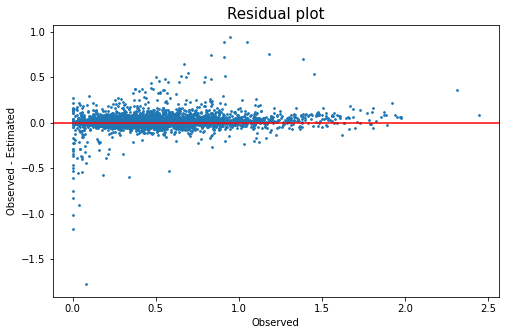

In [34]:
residual_plot(autoreg_Hs_test, linear_regress.predict(autoreg_test))

We can estimate the dependence of the target feature on time using the built-in autocorrelation function:

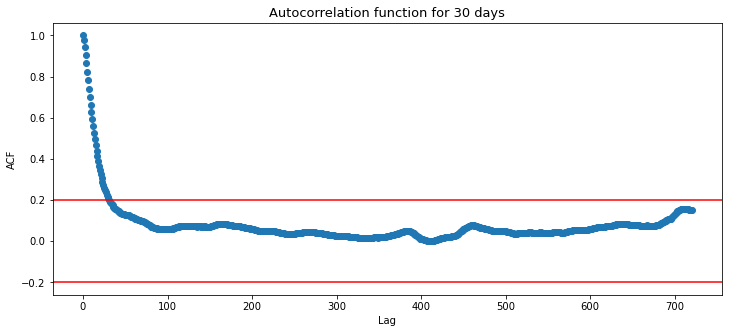

In [35]:
# showing the Autocorrelation function for 1 month:
samples = 30 * 24
acf_results = acf(autoreg_Hs["HS"], nlags = samples, fft = True)  # 720 records for 1 month

# autoreg_Hs

plt.figure(figsize = (12, 5))
plt.scatter(range(len(acf_results)), acf_results)
plt.axhline(0.2, c = "red")
plt.axhline(-0.2, c = "red")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.title(f'Autocorrelation function for {int(samples / 24)} days', fontsize=13)
plt.show()

Another built-in function is the Partial Autocorrelation 'pacf' that shows the importance of each 'lag' component on the target
feature.

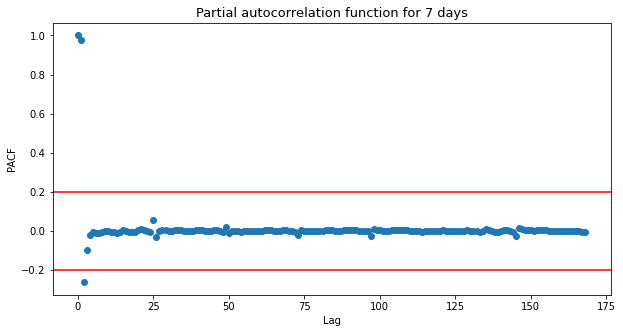

In [36]:
# plotting the Partial autocorrelation function for 1 week:
samples = 7*24
pacf_results = pacf(autoreg_Hs["HS"], nlags = samples)

plt.figure(figsize = (10, 5))
plt.scatter(range(len(pacf_results)), pacf_results)
plt.axhline(0.2, c = "red")
plt.axhline(-0.2, c = "red")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.title(f'Partial autocorrelation function for {int(samples / 24)} days', fontsize=13)
plt.show()

We show below the Mean and Standard deviation of the predicted (from the testing set) wave heights Hs as well as the 
coefficients of dependence of Hs on its previous (in time) values:

In [37]:
# the Average value:
(autoreg_Hs_test - linear_regress.predict(autoreg_test)).mean()

0.000861695540191349

In [38]:
# the Standard deviation:
(autoreg_Hs_test - linear_regress.predict(autoreg_test)).std()

0.05409162377468555

In [39]:
# Hs variable's dependence on its previous (in time) values:
linear_regress.coef_

array([ 1.20978155, -0.16167356, -0.06498971, -0.01074658,  0.00506434,
       -0.01061922])

As example, we plot a part of the predicted wave heights Hs (vs. Time) from the testing data set:

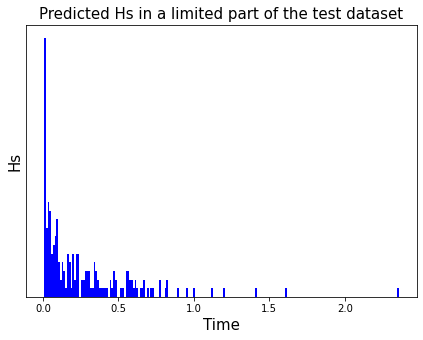

In [40]:
plot_histogram(linear_regress.predict(autoreg_test[-200:]))

# max(autoreg_Hs_test[-200:])  # 1.361
# max(linear_regress.predict(autoreg_test[-200:]))  # 1.3426...

Another way to split Time series keeping its chronological order is to devide the input data sets (sorted in time)
to first part (taking first 'n' records, where 'n' is chosen in way to have approximately 80% of all records) 
and second part (the rest of the records):

In [41]:
# Another way to split Time series (keeping the chronology):
autoreg_train_2 = autoreg_Hs[:-12500].drop("HS", axis = 1)  # first data records till the last 12500
# autoreg_train_2  # 48862 rows × 6 columns (61362 rows total in autoreg_Hs)
# autoreg_Hs  # 61362 rows × 7 columns
autoreg_Hs_train_2 = autoreg_Hs["HS"][:-12500]  # HS, Length: 48862, dtype: float64
autoreg_test_2 = autoreg_Hs[-12500:].drop("HS", axis = 1)  # last 12500 data records: (ind.=DateTime): 12500 r. × 6 col.
autoreg_Hs_test_2 = autoreg_Hs["HS"][-12500:]  # Length: 12500, dtype: float64

Now, we apply Linear Regression on the above prepared data set and find the scores for the new training and testing data sets.

In [42]:
# Score for the 2nd data split:
linear_regress.fit(autoreg_train_2, autoreg_Hs_train_2)

LinearRegression()

In [43]:
show_scores(linear_regress, autoreg_train_2, autoreg_test_2, autoreg_Hs_train_2, autoreg_Hs_test_2)

Train score: 0.9585916914744218
Test score: 0.9613412224362267


Finally, we determine the maximum predicted significant wave height Hs from the both data sets used above:

In [44]:
# Testing data predictions:
print("In the Autoregression model (not chronological data split):")
predict_value_func(linear_regress, autoreg_test, autoreg_Hs_test)

# Testing data predictions for the 2nd dataset:
print(f"Chronological Time split for the Autoregression model:")
predict_value_func(linear_regress, autoreg_test_2, autoreg_Hs_test_2)

In the Autoregression model (not chronological data split):
   maximum predicted Hs = 2.36 m
Chronological Time split for the Autoregression model:
   maximum predicted Hs = 2.44 m


## Dimensionality Reduction
In order to reduce the number of features in the input data set, Dimensionality Reduction can be applied. There are 
two main techniques for feature extraction in this approach: Principal Component Analysis (PCA) and Kernel PCA. The former 
is for linear transformation, the latter - for non-linear one.

### Scaling data
First, we divide the input data set to attributes & target variables for the future transformation:

In [45]:
hind_data = hindcast_t.copy()
# hind_data  # 61368 rows × 17 columns
hind_features = hind_data.drop("HS", axis = 1)
hind_target = hind_data["HS"]
# hind_features  # DataFrame (ind.=Date-Time, SORTED; named columns): 61368 rows × 16 columns
# hind_target  # Name: HS, Length: 61368, dtype: float64 (ind.=Date-Time, Sorted)

Now, we scale the data.

In [46]:
# hind_features
hind_features_scaled = MinMaxScaler().fit_transform(hind_features)  # or: MinMaxScaler((0, 1))  ???
# hind_features_scaled.shape  # (61368, 16)

In [47]:
hind_features_scaled.min(axis = 0), hind_features_scaled.max(axis = 0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

### Principal Component Analysis (PCA)
The linear transformation PCA increases the variance in the data. Using PCA leads to reduction of the smallest principal 
components resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [48]:
pca = PCA()

In [49]:
pca.fit(hind_features_scaled)  # 'hind_features_scaled' is an array that does NOT change after this 'fitting' !?
hind_features_pca = pca.transform(hind_features_scaled)

In [50]:
df_transformed = pd.DataFrame(hind_features_pca)
# hind_features_pca.shape  # array (61368, 16)
# df_transformed  # DataFrame (ind.: 0, 1, ..., 61367, col.: 0, 1, ... 15): 61368 rows × 16 columns

Some parameters of the PCA are obtained below. The coverance matrix shows the variances / co-variances of the scaled features.

In [51]:
# Finding the covariance matrix A =  Т^–1.D.Т :
covariance_matrix = pd.DataFrame(hind_features_scaled).cov()
covariance_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.072212,0.004428,-0.000991,-0.004814,-0.029780,-0.000334,-0.001226,-0.035736,-0.002575,-0.002786,-0.020020,-0.000913,-0.000576,-0.032355,-0.009850,-0.007245
1,0.004428,0.014228,0.002877,-0.001830,-0.009098,0.002442,0.014511,-0.003996,0.001955,-0.000344,-0.005313,0.004482,0.006490,-0.009869,-0.001903,-0.002241
2,-0.000991,0.002877,0.001428,0.001020,0.000678,0.001142,0.004055,0.001491,0.001237,0.000795,0.000859,0.001969,0.002587,0.000800,0.001415,0.001000
3,-0.004814,-0.001830,0.001020,0.026844,0.032518,0.000570,0.002692,0.017188,0.001802,0.018029,0.032320,0.001246,0.001450,0.036949,0.025041,0.026324
4,-0.029780,-0.009098,0.000678,0.032518,0.121137,-0.000141,0.000057,0.070642,0.003139,0.022258,0.096120,0.000166,-0.000766,0.131010,0.062918,0.066336
5,-0.000334,0.002442,0.001142,0.000570,-0.000141,0.001008,0.003237,0.000772,0.000632,0.000529,0.000080,0.001596,0.002116,-0.000160,0.001003,0.000580
6,-0.001226,0.014511,0.004055,0.002692,0.000057,0.003237,0.025551,0.007921,0.003523,0.003151,0.003743,0.006181,0.008790,0.000346,0.014460,0.011846
7,-0.035736,-0.003996,0.001491,0.017188,0.070642,0.000772,0.007921,0.095253,0.002858,0.012587,0.053442,0.001678,0.001679,0.077735,0.049262,0.049038
8,-0.002575,0.001955,0.001237,0.001802,0.003139,0.000632,0.003523,0.002858,0.002411,0.001084,0.003005,0.001627,0.002065,0.003682,0.001694,0.001668
9,-0.002786,-0.000344,0.000795,0.018029,0.022258,0.000529,0.003151,0.012587,0.001084,0.018266,0.028340,0.001025,0.001264,0.025449,0.019437,0.021108


In [52]:
pca.explained_variance_ratio_

array([6.23415671e-01, 1.13410336e-01, 8.82998262e-02, 5.09336424e-02,
       4.41406649e-02, 3.33514611e-02, 2.59561642e-02, 5.50064855e-03,
       4.34571352e-03, 4.12680092e-03, 3.25051193e-03, 1.72536430e-03,
       1.39500891e-03, 1.46976766e-04, 9.61556172e-07, 2.47470308e-07])

The cumulative sum of the variances for each feature can be found (computed and plotted):

In [53]:
np.cumsum(pca.explained_variance_ratio_)

array([0.62341567, 0.73682601, 0.82512583, 0.87605948, 0.92020014,
       0.9535516 , 0.97950777, 0.98500841, 0.98935413, 0.99348093,
       0.99673144, 0.99845681, 0.99985181, 0.99999879, 0.99999975,
       1.        ])

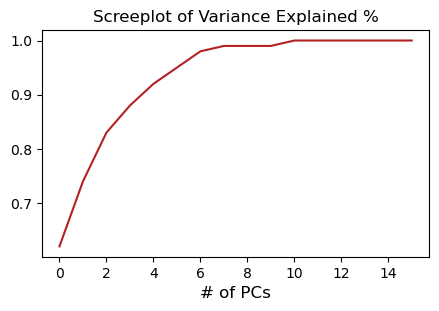

In [54]:
fig, axes = plt.subplots(1,1,figsize=(5, 3), dpi=100)
plt.plot(pca.explained_variance_ratio_.cumsum().round(2), color='firebrick')
plt.title('Screeplot of Variance Explained %', fontsize=12)
plt.xlabel('# of PCs', fontsize=12)
plt.show()

According to the cumulative sum of the 'explained variance ratio' (see the above plot) the first 6 components give 95% 
of the importance (variance). Thus, we can make second transformation keeping only the first 6 components as shown below.

## Exogenous model with reduced features¶
It is found in the above section that the PCA technique determines 6 main features containing 95% of the information what can be 
used to reduce the initial 16 variables. This approach is performed below.

Preparing datasets for PCA transformation

In [55]:
features_train, features_test, target_train, target_test = train_test_split(
    hind_features_scaled, hind_target, train_size = 0.8)

In [56]:
pca_6 = PCA(n_components=6)

Fitting the training set only:

In [57]:
pca_6.fit(features_train)

PCA(n_components=6)

Traansforming both the training and testing data sets:

In [58]:
pca_features_train = pca_6.transform(features_train)
pca_features_test = pca_6.transform(features_test)

Applying a Linear Regression on the PCA transformed data:

In [59]:
linear_regress.fit(pca_features_train, target_train)

LinearRegression()

Score results:

In [60]:
show_scores(linear_regress, pca_features_train, pca_features_test, target_train, target_test)  # ~ 0.84 both

Train score: 0.8458443159979091
Test score: 0.8504993674000648


The maximum predicted Significant wave height from the reduced data set is given below.

In [61]:
print("Linear Regression model with reduced dimensionality:")
predict_value_func(linear_regress, pca_features_test, target_test)

Linear Regression model with reduced dimensionality:
   maximum predicted Hs = 2.47 m


## COMBINED (Autoregression + Exogenous) Model
The third type of models for Time Series analysis is the model combining exogenous and endogenous (autoregression) approaches. 
The combined model uses shifted in time the searched variable (in our case: Hs) plus other (external) features.

In [62]:
hindcast_t.columns  # 17 features

Index(['WD', 'WS', 'ETOT', 'TP', 'VMD', 'ETTSea', 'TPSea', 'VMDSea', 'ETTSw',
       'TPSw', 'VMDSw', 'MO1', 'MO2', 'HS', 'DMDIR', 'ANGSPR', 'INLINE'],
      dtype='object')

In order to choose the features that are more important for the searched variable and not time-depending we can see the 
correlation coefficients - the lower the coefficients are, more independent the features are. Note that this dependence is 
linear one.

In [63]:
# hindcast_t  # 61368 rows × 17 columns
hindcast_t.corr()
# high correlated coeff.: HS = f(WS, ETOT, ETTSea, TPSea, ETTSw, MO1, MO2) - 7 variables
# low correlated coeff.: HS = f(WD, TP, VMD, VMDSea, TPSw, VMDSw, DMDIR, ANGSPR. INLINE) - 9 variables
#      WD        WS        ETOT      TP        VMD       ETTSea    TPSea     VMDSea    ETTSw     TPSw      VMDSw     MO1       MO2       HS        DMDIR     ANGSPR    INLINE
# HS: -0.075155; 0.722010; 0.892171; 0.198992; 0.071098; 0.819710; 0.844757; 0.165379; 0.665286; 0.185684; 0.115239; 0.935502; 0.948322; 1.000000; 0.075892; 0.272992; 0.227572

,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
WD,1.000000,0.138149,-0.097615,-0.109340,-0.318407,-0.039134,-0.028553,-0.430887,-0.195187,-0.076700,-0.209153,-0.064114,-0.029649,-0.075155,-0.316203,-0.119037,-0.093199
WS,0.138149,1.000000,0.638130,-0.093657,-0.219143,0.644794,0.761065,-0.108533,0.333787,-0.021356,-0.125056,0.708900,0.752320,0.722010,-0.217282,-0.051804,-0.064934
ETOT,-0.097615,0.638130,1.000000,0.164815,0.051532,0.951352,0.671214,0.127810,0.666853,0.155709,0.063846,0.983163,0.946592,0.892171,0.055621,0.121573,0.091434
TP,-0.109340,-0.093657,0.164815,1.000000,0.570253,0.109582,0.102771,0.339913,0.224033,0.814184,0.553808,0.143471,0.122370,0.198992,0.592257,0.496345,0.555417
VMD,-0.318407,-0.219143,0.051532,0.570253,1.000000,-0.012774,0.001017,0.657637,0.183705,0.473176,0.775336,0.009011,-0.030446,0.071098,0.988558,0.587079,0.658864
ETTSea,-0.039134,0.644794,0.951352,0.109582,-0.012774,1.000000,0.637650,0.078756,0.405347,0.123293,0.007070,0.948080,0.921266,0.819710,-0.013247,0.102535,0.063168
TPSea,-0.028553,0.761065,0.671214,0.102771,0.001017,0.637650,1.000000,0.160569,0.448859,0.145868,0.065736,0.729438,0.760383,0.844757,0.005692,0.293784,0.256187
VMDSea,-0.430887,-0.108533,0.127810,0.339913,0.657637,0.078756,0.160569,1.000000,0.188628,0.301753,0.486133,0.102543,0.075242,0.165379,0.661471,0.518366,0.549262
ETTSw,-0.195187,0.333787,0.666853,0.224033,0.183705,0.405347,0.448859,0.188628,1.000000,0.163417,0.171844,0.625127,0.581434,0.665286,0.196913,0.112012,0.117444
TPSw,-0.076700,-0.021356,0.155709,0.814184,0.473176,0.123293,0.145868,0.301753,0.163417,1.000000,0.588700,0.143142,0.129310,0.185684,0.494517,0.467048,0.539892


If linear dependence among the variables is supposed, the most independent from the Significant wave height, Hs features 
(with lower correlation coefficients) are: 

    HS = f(WD, TP, VMD, VMDSea, TPSw, VMDSw, DMDIR, ANGSPR. INLINE)
(see the notation at the beginning).

Another approach is to choose the important features for the model is to rely on the known investigations in the field of 
Coastal Engineering. It has been found there that the most important factor for wind-generated waves is wind thus we can choose 
as model parameters wind speed (WS), the total spectrum variance (ETOT), the peak spectral period of the total spectrum (TP), 
the first (MO1) and the second (MO2) spectral moments of the total spectrum (“supervised learning”):

    HS = f(WS, ETOT, TP, MO1, MO2).

In the code below, the second approach is applied and an appropriate function is prepared. This function takes the chosen above 
features, add to them time lags and a possible trend in time and creates new time dependent dataset. The time shift is chosen 
for 1 to 6 hours (time period for developing wind-generated waves) and 24 h (in order to investigate daily periodicity). 
The trend dependence (if any) is considered with 'diff' attribute: diff = 1 gives a linear trend; diff = 2 - second-order trend 
etc.)

In [64]:
# Reducing the features in the dataset:
# var. 1: Correlation coefficients low values in: 'WD', 'TP', 'VMD', 'VMDSea', 'TPSw', 'VMDSw', 'DMDIR', 'ANGSPR', 'INLINE'
# var. 2: Important features for HS (by experience): 'WS', 'ETOT', 'TP', 'MO1', 'MO2'

def shift_diff_func(inp_data_tab):
    comby_data = inp_data_tab.copy()
    # 'shift' presents Autoregression; 'diff' - shows Trend (diff =1 - linear trend; diff =2 - 'parobala' etc.)
    
    # var. 1: choosing the features (acc. to the correlation coefficients):
    # for var in ['HS', 'WD', 'TP', 'VMD', 'VMDSea', 'TPSw', 'VMDSw', 'DMDIR', 'ANGSPR', 'INLINE']:  # 'HS' + important features
    
    # var. 2: choosing the features (suppervized learning: 'WS', 'ETOT', 'TP', 'MO1', 'MO2'):
    for var in ['HS', 'WS', 'ETOT', 'TP', 'MO1', 'MO2']:  # taking 'HS' + the important features
    

        
        for lag in [1, 2, 3, 4, 6, 24]:  # shifted lags taken in hours: [1, 2, 3, 4, 6, 8, 24, 48]
            comby_data["{}_lag{}".format(var, lag)] = inp_data_tab[var].shift(lag)
        for difference in [1, 2]:
            comby_data["{}_diff{}".format(var, difference)] = inp_data_tab[var].diff(difference)
    comby_data = comby_data.dropna()
    return comby_data

Creating the DataFrame with new combined features for the target variable Hs (shifted in time and exogenous factors):

In [65]:
# Calling the function for 'shift' and 'differance' target rearrangement:
hindcast_t_comby = shift_diff_func(hindcast_t)
hindcast_t_comby  # DataFrame (inf.: DateTime, SORTED)

,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,...,MO1_diff1,MO1_diff2,MO2_lag1,MO2_lag2,MO2_lag3,MO2_lag4,MO2_lag6,MO2_lag24,MO2_diff1,MO2_diff2
DateTime,,,,,,,,,,,,,,,,,,,,,
2003-01-02 00:00:00,179.9,3.02,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,-0.01,-0.01,0.018,0.017,0.014,0.011,0.010,0.006,-0.018,-0.017
2003-01-02 01:00:00,183.9,2.94,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.00,-0.01,0.000,0.018,0.017,0.014,0.010,0.008,0.000,-0.018
2003-01-02 02:00:00,188.2,2.86,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.00,0.00,0.000,0.000,0.018,0.017,0.011,0.010,0.000,0.000
2003-01-02 03:00:00,192.7,2.78,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.00,0.00,0.000,0.000,0.000,0.018,0.014,0.011,0.000,0.000
2003-01-02 04:00:00,193.2,2.70,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.00,0.00,0.000,0.000,0.000,0.000,0.017,0.011,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,98.2,1.39,0.0,10.865,327.1,0.0,0.0,278.2,0.0,10.865,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.041,0.000,0.000
2009-12-31 20:00:00,89.8,1.38,0.0,10.849,326.3,0.0,0.0,269.8,0.0,10.849,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.037,0.000,0.000
2009-12-31 21:00:00,84.8,1.37,0.0,10.836,325.8,0.0,0.0,264.8,0.0,10.836,...,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.033,0.000,0.000


Below, we split the above found data set to training and testing sets.

In [66]:
comby_train, comby_test, comby_Hs_train, comby_Hs_test = train_test_split(
    hindcast_t_comby.drop("HS", axis = 1), hindcast_t_comby["HS"], train_size = 0.8)
# comby_train, comby_test, comby_Hs_train, comby_Hs_test are NOT sorted by time (index)
# but with many shifts (in time) of the target variable for use in the chosen model (Linear Regression)

Now, the linear regression model is launched:

In [67]:
linear_regress.fit(comby_train, comby_Hs_train)

LinearRegression()

The scores (R^2 coefficients) for the training and testing data sets from the above model are shown:

In [68]:
show_scores(linear_regress, comby_train, comby_test, comby_Hs_train, comby_Hs_test)

Train score: 1.0
Test score: 1.0


Some plots and main statistical parameters are printed in the next code:

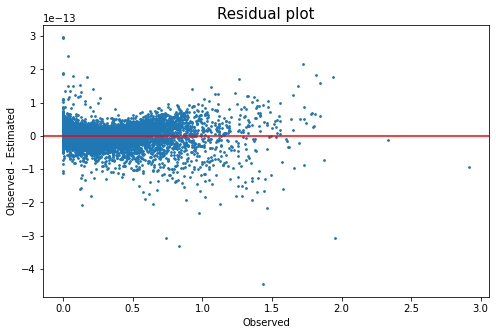

In [69]:
residual_plot(comby_Hs_test, linear_regress.predict(comby_test))

In [70]:
# the Average of the differance between the input testing data and its predicted values:
(comby_Hs_test - linear_regress.predict(comby_test)).mean()

4.513718873988548e-16

In [71]:
# the Standard deviation of the differance between the input testing data and its predicted values:
(comby_Hs_test - linear_regress.predict(comby_test)).std()

2.865531525540025e-14

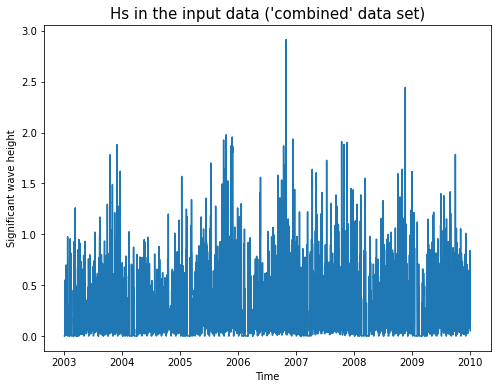

In [72]:
# plotting the Significant wave height for the recorded data:
plot_evolution(hindcast_t_comby, "HS", "Significant wave height", "Hs in the input data ('combined' data set)")

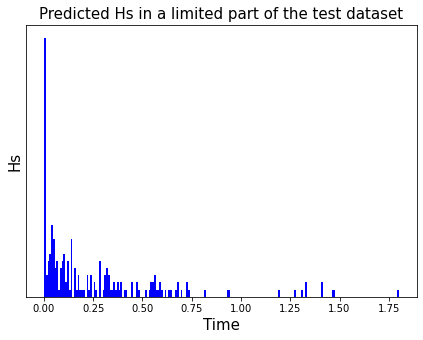

In [73]:
# plotting the predicted Significant wave height:
predicted_comby_set_part = linear_regress.predict(comby_test[-200:])
np_hist_pred_comby = predicted_comby_set_part  # combined_linear_model.predict(comby_test[-200:])

plot_histogram(np_hist_pred_comby)

For the same linear regression model, we can try another time split of the 'combined' data set dividing it to first 
(sorted in time) part and second (last) part.

In [74]:
# Another way to split Time series (keeping the chronology):
comby_train_2 = hindcast_t_comby[:-12500].drop("HS", axis = 1)  # first data records till the last 12500
# comby_train_2  # 48844 rows × 97 columns (61344 rows total in hindcast_t_comby)
comby_Hs_train_2 = hindcast_t_comby["HS"][:-12500]
# comby_Hs_train_2  # Length: 48844, dtype: float64
comby_test_2 = hindcast_t_comby[-12500:].drop("HS", axis = 1)  # the last 12500 data records
# comby_test_2  # 12500 rows × 97 columns (61344 rows total in hindcast_t_comby)
comby_Hs_test_2 = hindcast_t_comby["HS"][-12500:]
# comby_Hs_test_2  # HS, Length: 12500, dtype: float64

The scores of the second time split is found below:

In [75]:
# Score for the 2nd dataset:
linear_regress.fit(comby_train, comby_Hs_train)
show_scores(linear_regress, comby_train_2, comby_test_2, comby_Hs_train_2, comby_Hs_test_2)

Train score: 1.0
Test score: 1.0


Finally, we calculate the maximum predicted significant wave height Hs for the linear regression model from both splitting 
of the input 'combined' data set:

In [76]:
# Testing data predictions:
print("In the Combined model:")
predict_value_func(linear_regress, comby_test, comby_Hs_test)

print(f"2nd Time split in the Combined model:")
predict_value_func(linear_regress, comby_test_2, comby_Hs_test_2)

In the Combined model:
   maximum predicted Hs = 2.92 m
2nd Time split in the Combined model:
   maximum predicted Hs = 2.44 m


## Comparing the models and new testing
On the base of the training and testing scores, we compare the above models and choose the best one. The training and testing
scores (coefficients of determination R2) are as follows:
- Exogenous model: ~ 0,96 (for both data sets);
- Endogenous model (Autoregression): ~ 0,96 (for both data sets);
- Exogenous model with reduced features: ~ 0,85 for the training data set, ~0,84 for the testing data set;
- Combined model: 1 (for both data sets).

It is clear from the above scores that the best metrics has the Combined model followed by the Exogenous and Autoregression. 
It seems that the Combined method is overfitting (scores 1) but it includes the other two methods itself: the Exogenous 
and Autoregression. Moreover, it is known that the most important waves in Coastal Engineering design are wind-generated waves, 
so the target variable Significant wave height must include at least one wind parameter as feature for modeling (in addition 
to time). 

Thus, we choose to test the Combined and Exogenous models with a new Time Series data set (hindcast for 7 years: from 1996 
to 2002 with 1-hour daily records).

#### Reading and pre-processing the new dataset

In [77]:
# Reading the input *.csv file
delimiter = ';'

# # Reading the input *.csv table - LOCAL source:
# path_name = "D:\Geo_HP\Geo_ALL\PAPERS\OBOUCHENIE\SoftUni\PYTHON\Machine Learning\jupyter\project\Pointe-Noire_wave_data_2.csv"
# inp_hindcast_t_2 = pd.read_csv(path_name, sep=delimiter, header=[0, 1], low_memory=False)

# Reading the input *.csv table from Internet:
# https://github.com/Geo2020/Pointe-Noire/blob/main/Pointe-Noire_wave_data_2.csv  # old attempt
# https://raw.githubusercontent.com/Geo2020/Pointe-Noire/main/Pointe-Noire_wave_data_2.csv  # new attrmpt
path_name = "https://raw.githubusercontent.com/Geo2020/Pointe-Noire/main/Pointe-Noire_wave_data_2.csv"
inp_hindcast_t_2 = pd.read_csv(path_name, sep=delimiter, header=[0, 1], low_memory=False)

# inp_hindcast_t_2.head()
inp_hindcast_t_2  # 61368 rows × 19 columns

,CCYYMM,DDHHmm,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
,-,-,deg,m/s,m^2,sec,deg,m^2,sec,deg,m^2,sec,deg,m^2/s,m2/s2,m,deg,-,-
0,199601.0,10000.0,307.5,4.26,0.000,13.044,315.3,0.000,0.720,141.5,0.0,13.044,317.3,0.000,0.000,0.034,319.0,0.4932,0.9107
1,199601.0,10100.0,304.8,4.20,0.000,12.990,313.6,0.000,0.728,141.9,0.0,12.990,315.8,0.000,0.000,0.037,318.0,0.5446,0.8903
2,199601.0,10200.0,301.9,4.13,0.000,12.986,315.2,0.000,0.724,139.9,0.0,12.986,316.4,0.000,0.000,0.037,318.1,0.5621,0.8859
3,199601.0,10300.0,299.0,4.06,0.000,12.983,317.2,0.000,0.709,136.7,0.0,12.983,317.1,0.000,0.000,0.037,318.2,0.5909,0.8846
4,199601.0,10400.0,297.5,4.04,0.000,12.980,319.1,0.000,0.693,132.8,0.0,12.980,317.8,0.000,0.000,0.036,318.2,0.6123,0.8835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61363,200212.0,311900.0,126.1,3.33,0.000,1.375,320.1,0.000,1.301,320.1,0.0,0.917,320.1,0.000,0.001,0.063,320.5,0.9699,0.9449
61364,200212.0,312000.0,132.0,3.47,0.000,1.495,322.1,0.000,1.434,322.3,0.0,0.934,321.5,0.001,0.001,0.074,322.4,0.9732,0.9508
61365,200212.0,312100.0,137.3,3.61,0.000,1.631,324.5,0.000,1.574,324.9,0.0,0.987,322.1,0.001,0.002,0.088,324.7,0.9748,0.9535


We use the previously prepared function input_preprocess() for reading and pre-processing the new input data (from a *.csv file):

In [78]:
# Reading and pre-processing data (*.csv table):
hindcast_t_2 = input_preprocess(inp_hindcast_t_2)
# hindcast_t_2.dtypes  # dtype: object
# hindcast_t_2  # 61363 rows × 19 columns (DataFrame)

We can convert the date's and time's strings in the new data set to DateTime variables using our already coded function 
date_time_converting:

In [79]:
# Converting DateTime values:
hindcast_t_2 = date_time_converting(hindcast_t_2)
# hindcast_t_2  # 61363 rows × 18 columns

Then, we check if DateTime values are unique and set them as DataFrame index.

In [80]:
# Checking if DateTime are unique:
hindcast_t_2.DateTime.is_unique

True

In [81]:
# Setting 'DateTime' column as an index:
hindcast_t_2 = set_date_time_as_index(hindcast_t_2)

# hindcast_t_2.index  # dtype='datetime64[ns]', name='DateTime', length=61363
hindcast_t_2  # 61363 rows × 17 columns

,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
DateTime,,,,,,,,,,,,,,,,,
1996-01-01 00:00:00,307.5,4.26,0.000,13.044,315.3,0.000,0.720,141.5,0.0,13.044,317.3,0.000,0.000,0.034,319.0,0.4932,0.9107
1996-01-01 01:00:00,304.8,4.20,0.000,12.990,313.6,0.000,0.728,141.9,0.0,12.990,315.8,0.000,0.000,0.037,318.0,0.5446,0.8903
1996-01-01 02:00:00,301.9,4.13,0.000,12.986,315.2,0.000,0.724,139.9,0.0,12.986,316.4,0.000,0.000,0.037,318.1,0.5621,0.8859
1996-01-01 03:00:00,299.0,4.06,0.000,12.983,317.2,0.000,0.709,136.7,0.0,12.983,317.1,0.000,0.000,0.037,318.2,0.5909,0.8846
1996-01-01 04:00:00,297.5,4.04,0.000,12.980,319.1,0.000,0.693,132.8,0.0,12.980,317.8,0.000,0.000,0.036,318.2,0.6123,0.8835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 19:00:00,126.1,3.33,0.000,1.375,320.1,0.000,1.301,320.1,0.0,0.917,320.1,0.000,0.001,0.063,320.5,0.9699,0.9449
2002-12-31 20:00:00,132.0,3.47,0.000,1.495,322.1,0.000,1.434,322.3,0.0,0.934,321.5,0.001,0.001,0.074,322.4,0.9732,0.9508
2002-12-31 21:00:00,137.3,3.61,0.000,1.631,324.5,0.000,1.574,324.9,0.0,0.987,322.1,0.001,0.002,0.088,324.7,0.9748,0.9535


In [82]:
# replacing the missing (NaN) data with a linear interpolation of the missing values:
hindcast_t_2 = hindcast_t_2.interpolate("time")

# Description of the main statistical characteristics of the data set:
hindcast_t_2.describe().T

,count,mean,std,min,25%,50%,75%,max
WD,61363.0,214.537143,99.018991,0.00,145.8000,237.9000,295.3000,360.0000
WS,61363.0,3.553614,1.698918,0.29,2.2900,3.3600,4.6000,16.9900
ETOT,61363.0,0.004335,0.009533,0.00,0.0000,0.0010,0.0040,0.1540
TP,61363.0,4.212180,3.161512,0.00,1.6450,3.6720,7.3270,18.6370
VMD,61363.0,194.754318,143.244281,0.00,30.6000,304.8000,325.2000,360.0000
ETTSea,61363.0,0.002565,0.007543,0.00,0.0000,0.0000,0.0010,0.1480
TPSea,61363.0,1.186669,1.341347,0.00,0.0000,0.5930,2.2740,7.3320
VMDSea,61363.0,147.321324,126.998032,0.00,37.7000,113.4000,237.5000,400.0000
ETTSw,61363.0,0.001751,0.003853,0.00,0.0000,0.0000,0.0020,0.0780
TPSw,61363.0,4.666037,3.397819,0.00,1.7700,4.4890,7.3350,18.9270


#### Testing the Combined model with the new dataset

For the Combined model we can use our function for creating a dataset with rearrangement in time of the target variable:

In [83]:
# Calling the function for 'shift' and 'differance' target rearrangement:
hindcast_t_comby_new = shift_diff_func(hindcast_t_2)
hindcast_t_comby_new  # 61339 rows × 65 columns

,WD,WS,ETOT,TP,VMD,ETTSea,TPSea,VMDSea,ETTSw,TPSw,...,MO1_diff1,MO1_diff2,MO2_lag1,MO2_lag2,MO2_lag3,MO2_lag4,MO2_lag6,MO2_lag24,MO2_diff1,MO2_diff2
DateTime,,,,,,,,,,,,,,,,,,,,,
1996-01-02 00:00:00,279.7,2.58,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,...,-0.002,-0.002,0.004,0.003,0.003,0.002,0.001,0.000,-0.004,-0.003
1996-01-02 01:00:00,278.7,2.59,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,...,0.000,-0.002,0.000,0.004,0.003,0.003,0.002,0.000,0.000,-0.004
1996-01-02 02:00:00,277.7,2.60,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.004,0.003,0.002,0.000,0.000,0.000
1996-01-02 03:00:00,276.8,2.62,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.004,0.003,0.000,0.000,0.000
1996-01-02 04:00:00,276.8,2.71,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-31 19:00:00,126.1,3.33,0.000,1.375,320.1,0.000,1.301,320.1,0.0,0.917,...,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.038,0.000,0.000
2002-12-31 20:00:00,132.0,3.47,0.000,1.495,322.1,0.000,1.434,322.3,0.0,0.934,...,0.001,0.001,0.001,0.001,0.001,0.000,0.000,0.034,0.000,0.000
2002-12-31 21:00:00,137.3,3.61,0.000,1.631,324.5,0.000,1.574,324.9,0.0,0.987,...,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.030,0.001,0.001


Statistical characteristics for the ‘combined’ data set:

In [84]:
hindcast_t_comby_new.describe().T

,count,mean,std,min,25%,50%,75%,max
WD,61339.0,2.145043e+02,99.024400,0.000,145.700,237.800,295.200,360.000
WS,61339.0,3.553192e+00,1.699089,0.290,2.290,3.360,4.600,16.990
ETOT,61339.0,4.336817e-03,0.009534,0.000,0.000,0.001,0.004,0.154
TP,61339.0,4.211012e+00,3.159506,0.000,1.645,3.672,7.327,18.637
VMD,61339.0,1.947397e+02,143.256071,0.000,30.600,304.800,325.200,360.000
...,...,...,...,...,...,...,...,...
MO2_lag4,61339.0,1.310884e-02,0.026358,0.000,0.000,0.002,0.013,0.316
MO2_lag6,61339.0,1.310885e-02,0.026358,0.000,0.000,0.002,0.013,0.316
MO2_lag24,61339.0,1.310814e-02,0.026358,0.000,0.000,0.002,0.013,0.316
MO2_diff1,61339.0,-5.656184e-23,0.006769,-0.196,0.000,0.000,0.000,0.186


Now we divide the 'combined' data to features and target variables. Since the new input data serve us only for testing 
we make one set for the chosen features and one – for the target variable.

In [85]:
# hindcast_t_comby_new  # 61339 rows × 65 columns
comby_features_new = hindcast_t_comby_new.drop("HS", axis = 1)
# comby_features_new  # 61339 rows × 64 columns
comby_Hs_new = hindcast_t_comby_new["HS"]
# comby_Hs_new  # HS, Length: 61339, dtype: float64

We launch linear regression for the new dataset prepared according to the technique given in the Combined model.

In [86]:
linear_regress.fit(comby_features_new, comby_Hs_new)

LinearRegression()

In [87]:
print("The Combined model's score for the new data set: {}".format(linear_regress.score(comby_features_new, comby_Hs_new)))

The Combined model's score for the new data set: 1.0


Finally, we obtain the maximum predicted Significant wave height and compare it with the maximum of the recorded (hindcasted) 
wave heights in the new data set.

In [88]:
# Testing data set's prediction:
print("The Combined model applied to the testing set:")
predict_value_func(linear_regress, comby_features_new, comby_Hs_new)

print(f"Really recorded (hindcasted) maximum Significant wave height in the 2nd Test: Hs = {max(comby_Hs_new)} m")

The Combined model applied to the testing set:
   maximum predicted Hs = 1.57 m
Really recorded (hindcasted) maximum Significant wave height in the 2nd Test: Hs = 1.57 m


#### Testing the Exogenous model with the new dataset
For the Exogenous model, we split the new data set to features and target sets (no training the model):

In [89]:
# hindcast_t_2  # 61363 rows × 17 columns
exo_features = hindcast_t_2.drop("HS", axis = 1)
exo_target = hindcast_t_2["HS"]

# hindcast_t_2  # 61363 rows × 17 columns
# exo_features  # DataFrame (ind.: DateTime, sorted): 61363 rows × 16 columns
# exo_target  # HS, Length: 61363, dtype: float64

Launching the Exogenous model with the new data:

In [90]:
linear_regress.fit(exo_features, exo_target)

LinearRegression()

The score result for the new data set.

In [91]:
# Score results:
print("Test score: {}".format(linear_regress.score(exo_features, exo_target)))

Test score: 0.949385251774665


Lastly, we obtain the maximum predicted Significant wave height from the new data.

In [92]:
# Testing data prediction
print("New Test for the Exogenous model:")
predict_value_func(linear_regress, exo_features, exo_target)

New Test for the Exogenous model:
   maximum predicted Hs = 1.97 m


Comparing the predicted results from both the Combined and Exogenous models obtained from  the new time series data, we conclude
that higher is the Significant wave height, Hs from the Exogenous model. The latter will be used for prediction of Hs as more 
conservative (extreme) case for Engineering design purpose.

### Comparing the predicted wave heights with that from the Weibull distribution (Long-term Statistics)

For long-term statistics wave data records of sufficient durations are needed (typically, 5-10 years). 
In [Coastal Engineering Manual] is stated:

"Statistical methods for analyzing long-term information cover many years. To obtain long-term wave statistics, a 15-min record 
may have been recorded (and statistics of each record computed) every 3 hr for 10 years (about 29,000 records) and the 
statistics of the set of 29,000 significant wave heights compiled." 
"Typical time period for Long-term Statistics is 20 years ..."

Our two input data sets give about 63,000 wave records each for total period of 14 years, thus we can use them for long-term 
wave climate analysis.

The predicted Significant wave height for long time period (many years) is important design parameter in Hydrotechnics. 
In Coastal engineering practice Weibull distribution is recommended for such calculations.
For this purpose, we use the new data set covering time period of 7 years (from 1996 to 2002).

The probability of exceedance of the Significant wave height corresponding to a chosen return period (the average period 
of time between occurrences of a higher wave height) depends on the time interval of daily wave records [Coastal Engineering 
                                                                                                            Manual]: 

In [93]:
# Return period, Tr in years:
t_r = 1

In [94]:
# Probability of exceedance of Hs for Tr-year return period:
pr_exc = 1/ (t_r * 365.25 * 24)
print(f"The probability of exceedance of Hs for {t_r}-year return period and 1h daily records: {pr_exc}")

The probability of exceedance of Hs for 1-year return period and 1h daily records: 0.00011407711613050422


The Weibull distribution parameters are: A (scale), B (location), k (shape). 

In [95]:
# The recommended coefficients: k = 1, B = 0 and A calculated as:
a_w = hindcast_t_comby_new['HS'].std()

The Significant wave height for Tr-year Return period is fond to be:

In [96]:
# Hs for Tr-year return period:
h_w = a_w * (-math.log(pr_exc))
print(f"The predicted Significant wave height from the Weibull distribution for {t_r}-year return period: {h_w:.2f} m")

The predicted Significant wave height from the Weibull distribution for 1-year return period: 1.80 m


Now, we compare the above value (Hs max) with those from the Combined and Exogenous models (see the previous sections). 
Analyzing the results, we see that the prediction of the Significant wave height from the Exogenous model corresponds closer 
to the same parameter obtained from the Weibull distribution for 1-year Return period.

Thus, the investigated Significant wave height is modelled better with the Exogenous model, i.e. it does not depend on time. 
As a fact the time series input data sets are too long (7-year period with hourly records) and might be considered as 
independent on time.

## Conclusion:
In the present project, hindcast outputs of the wave simulation model MSC50 are used to investigate the most important for 
engineering design wave parameter “significant wave height”. The hindcast characteristics in form of Time Series are obtained 
from the Meteorological Service of Canada and consist of two data sets (*.csv files) covering 14-year period (from 1996 to 2009) 
with 1-hour daily records. 

For the project purpose, the three main models in the Time Series analysis are applied to the first hindcast dataset: 
Exogenous model, Endogenous (or Autoregression) and Combined method (including combinations of the previous two models). 
In addition, Dimensionality Reduction with PCA technique is performed to reduce all features to a few most important, which are
used again in the Exogenous model. The score result for the reduced features (R^2 ~ 0,85) shows that the PCA technique is 
acceptable for modelling in our case. 

After training the above models (applying Linear regression), the second dataset is taken for a new testing. Comparing the 
performance of our models (namely, the coefficients of determination R^2) we conclude that the most precise are to be the 
Combined and Exogenous models that and both are used for the second testing. The outcomes showed that the two models perform 
well but the Combined model seems to be overfitting (score = 1). This was the reason to compare their results (the maximum 
predicted Significant wave height) with the conventional prediction fulfilled with the Weibull distribution formulae. 
The conclusion is that the Exogenous model giving higher result is closer to the Weibull distribution prediction: the predicted 
maximum Significant wave height, Hs in the Exogenous model from 7-year Time Series is comparable with Hs calculated from 
the Weibull distribution for 1-year return period.

## Future work

Our work can be continued with new research, in which relation between the two main wave characteristics, namely the Significant
wave height, Hs and the Peak Spectral Period of total spectrum, TP is to be found.

Another direction for future work is to find a model that divides the Significant wave height into groups (classes) by compass 
directions (8 or 16, for ex. N, (NNE), NE, (ENE), E etc.) performing analogical to the given here modelling.

It is important as well to predict the Significant wave height (respectively, the Peak Spectral period) for long period of time 
(50- or 100-year Return period) – commonly used wave parameters in Coastal Engineering.

More generally, the above scope of work is to be done for models not associated with Time Series, i.e. considering the main 
wave characteristics as time independent.

## References

1. U.S. Army Corps of Engineers. 2002. Coastal Engineering Manual. Engineer Manual 1110-2-1100, U.S. Army Corps of Engineers, 
Washington, D.C. (in 6 volumes).

2. Goda, Y (2000) "Random seas and design of maritime structures". In: P L-F Liu (ed) Advanced Series on Ocean Engineering, 
vol.15, World Scientific, Singapore, 443 p.

3. CIRIA, CUR, CETMEF (2007). The Rock Manual. The use of rock in hydraulic engineering (2nd edition). C683, CIRIA, London 
1267 p.